In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd ./drive/MyDrive/VehicleDetection_Yolov6/test_detectron2

/content/drive/MyDrive/VehicleDetection_Yolov6/test_detectron2


In [3]:
%pwd

'/content/drive/MyDrive/VehicleDetection_Yolov6/test_detectron2'

In [4]:
#import neccessary library
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import random
from PIL import Image,ImageDraw
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Function to get the data from XML Annotation

def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [7]:
# test extract xml info
print(extract_info_from_xml('./images/test/frame104.xml'))

{'bboxes': [{'class': 'car', 'xmin': 374, 'ymin': 268, 'xmax': 762, 'ymax': 624}, {'class': 'motorcycle', 'xmin': 654, 'ymin': 154, 'xmax': 712, 'ymax': 262}, {'class': 'car', 'xmin': 305, 'ymin': 160, 'xmax': 417, 'ymax': 239}, {'class': 'car', 'xmin': 531, 'ymin': 133, 'xmax': 622, 'ymax': 205}, {'class': 'car', 'xmin': 693, 'ymin': 114, 'xmax': 754, 'ymax': 165}], 'filename': 'frame104', 'image_size': (1280, 720, 3)}


In [10]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"car": 0,
                           "motorcycle": 1,
                           "truck": 2}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolo(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
          # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("images/test", f'{info_dict["filename"]}.txt')
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [8]:
annotations = [os.path.join('images/test', x) for x in os.listdir('images/test') if x[-3:] == "txt"]
print(annotations)

[]


In [11]:
# Get the annotations
annotations = [os.path.join('images/test', x) for x in os.listdir('images/test') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolo(info_dict)
annotations = [os.path.join('images/test', x) for x in os.listdir('images/test') if x[-3:] == "txt"]

100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


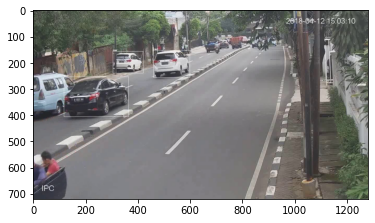

In [ ]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()
    

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)
#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [13]:
%cd /content/drive/MyDrive/VehicleDetection_Yolov6/test_detectron2/images/test

!mkdir test_labels
!mv *.txt test_labels

/content/drive/MyDrive/VehicleDetection_Yolov6/test_detectron2/images/test


In [ ]:
%cd /content/drive/MyDrive/VehicleDetection_Yolov6/test_detectron2/images/test


In [14]:
import os

dir_name = "/content/drive/MyDrive/VehicleDetection_Yolov6/test_detectron2/images/test/"
test = os.listdir(dir_name)

for item in test:
    if item.endswith(".xml"):
        os.remove(os.path.join(dir_name, item))